In [1]:
#read news-excess return csv file
import pandas as pd
import time

txt_data = pd.read_csv('final_txt_excessret.csv',index_col = 0)
# txt_data = pd.read_csv('final_txt_excessret_1.csv',index_col = 0)
txt_data = txt_data.fillna('')
txt_data.loc[txt_data['description']=='Seeking Alpha','description'] = ''
#if news doesn't have body part, use head instead
txt_data.loc[txt_data.txt=='','txt'] = txt_data.loc[txt_data.txt==''].apply(
    lambda X: X['head']+X.description+X.txt,axis = 1)
txt_data.head()#'txt' column is what I'm going to use

,ticker,head,description,txt,datadate,ret
0,XXII,BRIEF-22nd Century ?CEO Henry Sicignano To Dis...,* 22ND CENTURY - CO'S CEO HENRY SICIGNANO III ...,March 19 (Reuters) - 22Nd Century Group Inc: *...,20180319,0.014204
1,XXII,BRIEF-22ND CENTURY GROUP TO DISCONTINUE U.S. S...,* 22ND CENTURY GROUP INC - WILL DISCONTINUE U....,Nov 22 (Reuters) - 22nd Century Group Inc: * 2...,20171122,0.017992
2,XXII,BRIEF-22nd century receives guidance from FDA ...,* 22Nd century receives guidance from FDA on p...,June 22 (Reuters) - 22nd Century Group Inc : *...,20170622,0.022555
3,XXII,BRIEF-22nd Century entered into warrant exerci...,* 22nd Century - entered into warrant exercise...,June 19 (Reuters) - 22nd Century Group Inc: * ...,20170619,-0.024741
4,XXII,"BRIEF-22nd Century, Dent Neurosciences Researc...",* 22nd century and Dent Neurosciences Research...,June 8 (Reuters) - 22nd Century Group Inc: * 2...,20170608,-0.000267


In [2]:
txt_data_n = pd.read_csv('final_txt_excessret.csv',index_col = 0)

In [3]:
txt_data_n.columns = ['ticker','head','description','txt','datadate','ret_1']

# 1. Cleaning and tokenizing part

In [4]:
import numpy as np

# for nice number printing
np.set_printoptions(precision=3, suppress=True)

# tokenize and clean the text
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from collections import Counter
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
# tokenize anything that is not a number and not a symbol
word_tokenizer = RegexpTokenizer(r'[^\d\W]+')


sno = SnowballStemmer('english')
wnl = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')
# get our list of stop_words
stop_words = set(stopwords.words('english')) 
# add some extra stopwords
stop_words |= {"may", "business", "company", "could", "service", "result", "product", 
               "operation", "include", "law", "tax", "change", "financial", "require",
               "cost", "market", "also", "user", "plan", "actual", "cash", "other",
               "thereto", "thereof", "therefore"}
# convert text into bag-of-words
def clean_text(txt):
    lemm_txt = [ wnl.lemmatize(wnl.lemmatize(w.lower(),'n'),'v') \
                for w in word_tokenizer.tokenize(txt) if \
                w.isalpha() and w not in stop_words ]
    return [ sno.stem(w) for w in lemm_txt if w not in stop_words and len(w) > 2 ]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guoji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\guoji\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
txt_data['clean_txt'] = txt_data['txt'].apply(str).apply(clean_text)
txt_data = txt_data.sort_values('datadate').reset_index(drop = True)
txt_data['clean_txt'].head()

0    [reuter, chief, execut, lockhe, martin, corp, ...
1             [world, weekend, updat, anoth, mix, bag]
2    [hors, dead, whip, win, help, time, dismount, ...
3                             [germani, economi, take]
4    [dubai, reuter, iran, say, sunday, negoti, pay...
Name: clean_txt, dtype: object

# 2. Choosing Sentimental-charged words

In [6]:
# '''total word set'''
# '''will cost 8 hours, don't run this cell!!'''
# words_set = set([k for x in txt_data['clean_txt'].tolist() for k in x])

# word_arr = np.array(list(words_set),dtype = 'str')

# word_list = txt_data['clean_txt'].values.tolist()

# word_sig = pd.DataFrame(columns = ['word','total_times','proportion','aver_ret'])
# start = time.time()
# for k in range(len(word_arr)):
#     tmp = txt_data.loc[txt_data['clean_txt'].apply(lambda x: word_arr[k] in x),'ret']
#     word_sig = word_sig.append({'word':word_arr[k],
#                                 'total_times':len(tmp),
#                                 'proportion':len(tmp[tmp>0])/len(tmp),
#                                 'aver_ret':tmp.mean()},
#                                ignore_index = True)
# word_sig.to_csv('word_sig.csv')

In [7]:
#setting threshold for word subsets selection
word_sig = pd.read_csv('word_sig.csv',index_col = 0)
times = 400
posi_proportion = 0.54
nega_proportion = 0.46

posi_words = word_sig.loc[(word_sig.total_times>times)
                          &(word_sig.proportion>posi_proportion),'word'].values.tolist()
nega_words = word_sig.loc[(word_sig.total_times>times)
                          &(word_sig.proportion<nega_proportion),'word'].values.tolist()
total_s = posi_words+nega_words

In [8]:
posi_dict = word_sig.loc[(word_sig.total_times>times)
                          &(word_sig.proportion>posi_proportion),['word','total_times']].set_index('word').to_dict().get('total_times')
nega_dict = word_sig.loc[(word_sig.total_times>times)
                          &(word_sig.proportion<nega_proportion),['word','total_times']].set_index('word').to_dict().get('total_times')

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
posi_cloud = WordCloud(background_color="white",width = 1400,height = 800,prefer_horizontal=1).generate_from_frequencies(posi_dict)
nega_cloud = WordCloud(background_color="white",width = 1400,height = 800,prefer_horizontal=0.9).generate_from_frequencies(nega_dict)

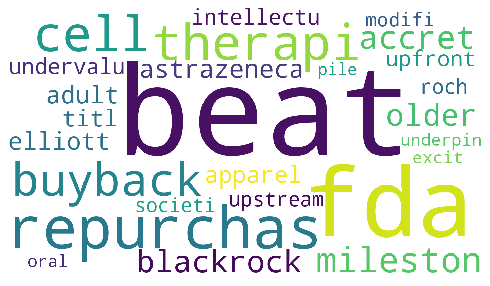

In [10]:
plt.figure(figsize=(10,5))
plt.imshow(posi_cloud)
# plt.imshow(nega_cloud)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 800 
plt.axis("off")
# plt.savefig('nega_cloud.jpg',dpi = 800)
plt.savefig('posi_cloud.jpg',dpi = 800)
plt.show()

# 3. Model construction

In [11]:
def build_submatrix(X, word_list):
    tmp_dic = {i:0 for i in word_list}
    for x in X:
        if x in tmp_dic.keys():
            tmp_dic[x] += 1
    return np.array(list(tmp_dic.values()))

In [12]:
#build news submatrix
txt_data['head_mat'] = txt_data.clean_txt.apply(build_submatrix, 
                                                args = (total_s, )).apply(np.reshape, args = (322,))
txt_data['head_mat'].tail()

140393    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
140394    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
140395    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
140396    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
140397    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: head_mat, dtype: object

In [13]:
#Filtering all of news, keep news which contains at least 2 sentimental-charged words
useful_txt = txt_data[txt_data.head_mat.apply(sum)>1].copy().reset_index(drop = True)

In [14]:
#Setting training set
train_txt = useful_txt.iloc[:20000].copy()
#Counting sentiment score
train_txt['ret_rank'] = train_txt.ret.rank(pct = True)
#Generating return-rank of return DataFrame for next step
return_df = train_txt[['ret','ret_rank']].copy().sort_values('ret').reset_index(drop = True)

In [15]:
W = np.mat(np.vstack([train_txt.ret.rank(pct = True).values,
                      1-train_txt.ret.rank(pct = True).values]),
           dtype='float64')

In [16]:
train_txt.head_mat = train_txt.head_mat/train_txt.head_mat.apply(sum)
tmp_arr = train_txt.head_mat[0]
for i in range(1,len(train_txt)):
    tmp_arr = np.vstack([tmp_arr,train_txt.head_mat[i]])

In [17]:
D = np.mat(tmp_arr).T

## Calculating Matrix O by following OLS formula
$O=D\cdot W^\prime\cdot (W\cdot W^\prime)^{-1}$

In [18]:
#calculating O
O_df = pd.DataFrame(D*W.T*(W*W.T).I,columns = ['o+','o-'],index = total_s)
O_df.loc[O_df['o+']<0,'o+'] = 0
O_df.loc[O_df['o-']<0,'o-'] = 0
O_df = O_df.apply(lambda x: x/x.sum(),axis = 0)

In [20]:
O_df.head()

,o+,o-
repurchas,0.029047,0.009089
upfront,0.004270,0.000691
cell,0.008193,0.004599
mileston,0.007706,0.003204
therapi,0.008465,0.004727


In [21]:
def likelihood_func(p,arr_sam,O_df,penalty):
    return np.sum(np.log((O_df['o+'].values*p+O_df['o-'].values*(1-p))**arr_sam))+penalty*np.log(p*(1-p))
def count_prediction(sample_arr, O_df, return_df, penalty):
    index_max = return_df['ret_rank'].apply(likelihood_func,args = (sample_arr, O_df, penalty, )).values.argmax()
    return return_df.loc[index_max].values

## Testing results

In [ ]:
#Setting testing sample
test_txt = useful_txt.iloc[20000:50000].copy()
test_txt['prediction']= test_txt.head_mat.apply(count_prediction,args = (O_df, return_df, 10))

In [ ]:
test_txt.to_csv('NLP_result.csv')

In [21]:
test_txt_n = pd.merge(test_txt,txt_data_n[['txt','ret_1']],on = 'txt', how = 'inner')

In [22]:
np.corrcoef(test_txt_n.ret_1.values,test_txt_n.prediction.apply(lambda x: x[0]).values)

array([[1.   , 0.003],
       [0.003, 1.   ]])

In [23]:
np.corrcoef(test_txt_n.ret.values,test_txt_n.prediction.apply(lambda x: x[0]).values)

array([[1.   , 0.043],
       [0.043, 1.   ]])

In [24]:
new_res =pd.DataFrame({'factor':test_txt_n.prediction.apply(lambda x: x[1]).values, 
                       'date':pd.to_datetime(test_txt_n['datadate'],format = '%Y%m%d'),
                       'ret_1':test_txt_n.ret.values,
                      'ret_2':test_txt_n.ret_1.values})
new_res.head()

,date,factor,ret_1,ret_2
0,2017-10-19,0.486900,-0.015131,-0.004120
1,2017-10-19,0.434475,0.023899,-0.003990
2,2017-10-19,0.494250,-0.010347,0.001264
3,2017-10-19,0.485000,-0.023988,-0.003386
4,2017-10-19,0.453425,-0.003386,0.003460


In [25]:
pnl = pd.DataFrame({
#     'Mean': new_res.groupby('date').apply(lambda X: X['ret'].mean() if (len(X)>10) else 0),
                    't+1':new_res.groupby('date').apply(lambda X: X['ret_1'][X['factor']>0.5].mean()-X['ret_1'][X['factor']<0.5].mean()
                                                             if (len(X)>10) else 0),
                    't+2':new_res.groupby('date').apply(lambda X: X['ret_2'][X['factor']>0.5].mean()-X['ret_2'][X['factor']<0.5].mean()
                                                             if (len(X)>10) else 0)})
pnl.head()

,t+1,t+2
date,,
2017-10-19,0.065771,0.017836
2017-10-20,-0.024721,-0.005514
2017-10-23,0.008669,0.002561
2017-10-24,0.014815,0.001469
2017-10-25,0.002293,-0.002288


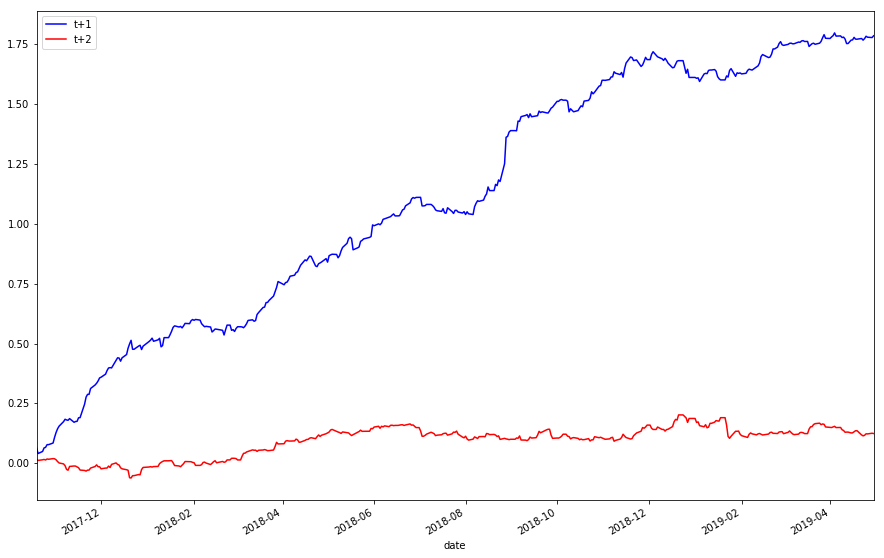

In [46]:
%matplotlib inline
pnl.cumsum().plot(figsize = (15,10),color = ['b','r'])

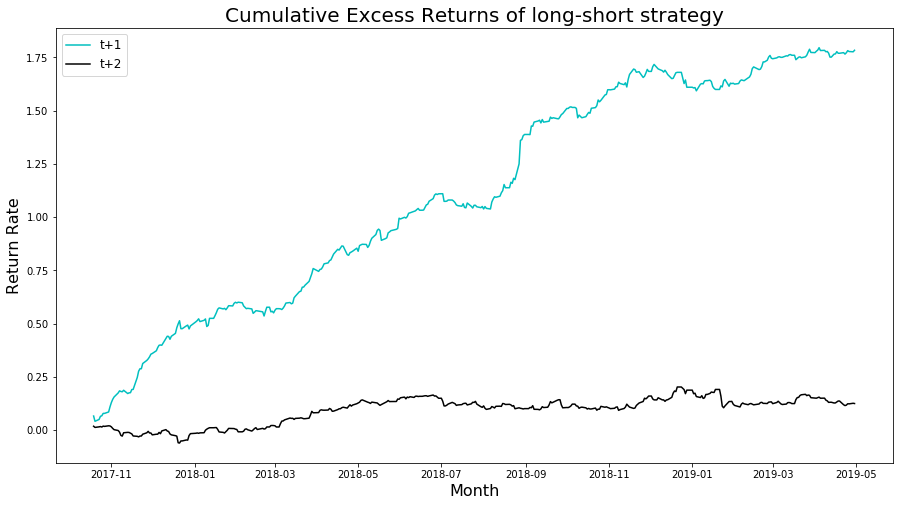

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,8))
plt.plot(pnl.iloc[:,0].cumsum(),color = 'c')
plt.plot(pnl.iloc[:,1].cumsum(),color = 'k')
plt.legend(['t+1','t+2'],fontsize='large')
plt.xlabel("Month", fontsize=16)
plt.ylabel("Return Rate", fontsize=16)
plt.title("Cumulative Excess Returns of long-short strategy", fontsize=20)
plt.savefig('long_short_comparasion.png',dpi = 300)
plt.show()

In [52]:
pnl_n = pd.DataFrame({
#     'Mean': new_res.groupby('date').apply(lambda X: X['ret'].mean() if (len(X)>10) else 0),
                    'positive_long':new_res.groupby('date').apply(lambda X: X['ret_1'][X['factor']>0.5].mean()
                                                             if (len(X)>15) else 0),
                     'negative_short':new_res.groupby('date').apply(lambda X: -X['ret_1'][X['factor']<0.5].mean()
                                                             if (len(X)>15) else 0)})
pnl_n.head()

,negative_short,positive_long
date,,
2017-10-19,0.010831,0.054940
2017-10-20,0.010469,-0.035190
2017-10-23,0.016227,-0.007557
2017-10-24,0.009365,0.005450
2017-10-25,0.006659,-0.004366


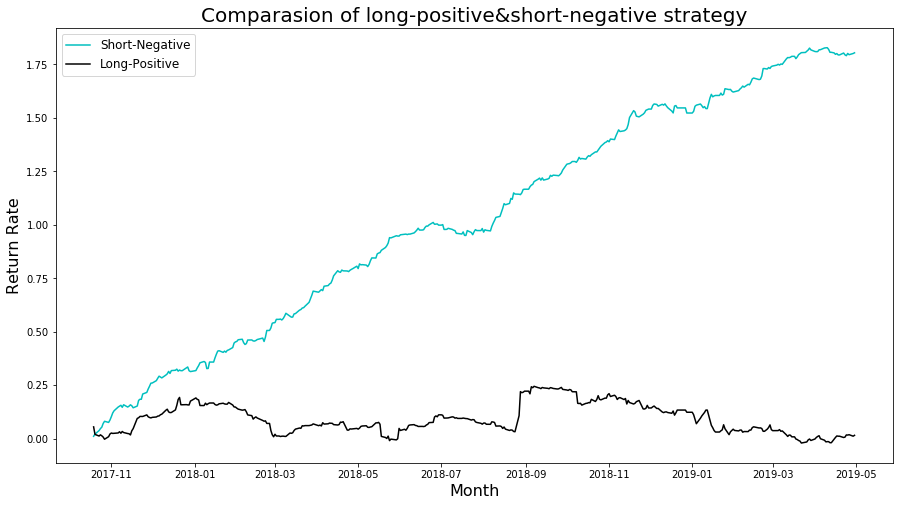

In [62]:
plt.figure(figsize = (15,8))
plt.plot(pnl_n.iloc[:,0].cumsum(),color = 'c')
plt.plot(pnl_n.iloc[:,1].cumsum(),color = 'k')
plt.legend(['Short-Negative','Long-Positive'],fontsize='large')
plt.xlabel("Month", fontsize=16)
plt.ylabel("Return Rate", fontsize=16)
plt.title("Comparasion of long-positive&short-negative strategy", fontsize=20)
plt.savefig('long_strategy.png',dpi = 300)
plt.show()

In [99]:
pnl.append(pnl_n)

,Zerocost
date,
2017-10-19,0.030652
2017-10-20,-0.011159
2017-10-21,0.000000
2017-10-22,0.000000
2017-10-23,0.003471
2017-10-24,0.008606
2017-10-25,0.000890
2017-10-26,0.007270
2017-10-27,-0.000431
